In [3]:
import os
import mne
import numpy as np
import pandas
from tqdm.notebook import tqdm
import warnings
import scipy.signal as signal
from scipy.integrate import simps
from mne_icalabel import label_components
warnings.filterwarnings("ignore")


In [4]:
#Load eeg raw file

raw=mne.io.read_raw_fif('part_fif_raw.fif',preload=True)
raw.drop_channels(['Packet Counter','TRIGGER', 'ACC21', 'ACC22', 'ACC23','ExG 1'])
raw.set_montage('standard_1020')
raw.filter( 1, 40)

Opening raw data file part_fif_raw.fif...
Isotrak not found
    Range : 0 ... 37506 =      0.000 ...    75.012 secs
Ready.
Reading 0 ... 37506  =      0.000 ...    75.012 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



<Raw | part_fif_raw.fif, 20 x 37507 (75.0 s), ~5.8 MB, data loaded>

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.4s.
Creating RawArray with float64 data, n_channels=20, n_times=37507
    Range : 0 ... 37506 =      0.000 ...    75.012 secs
Ready.
Opening ica-browser...


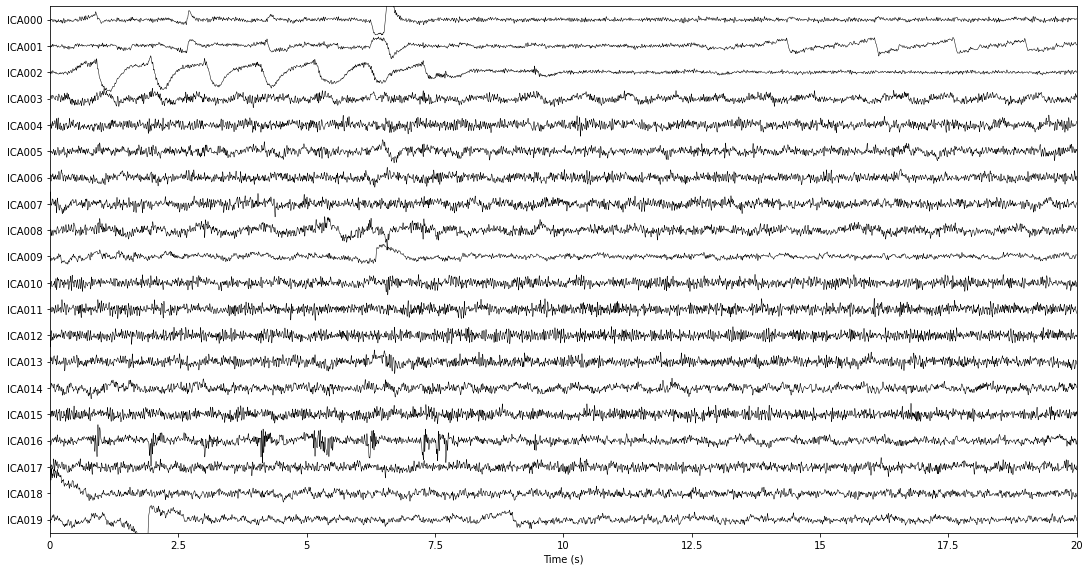

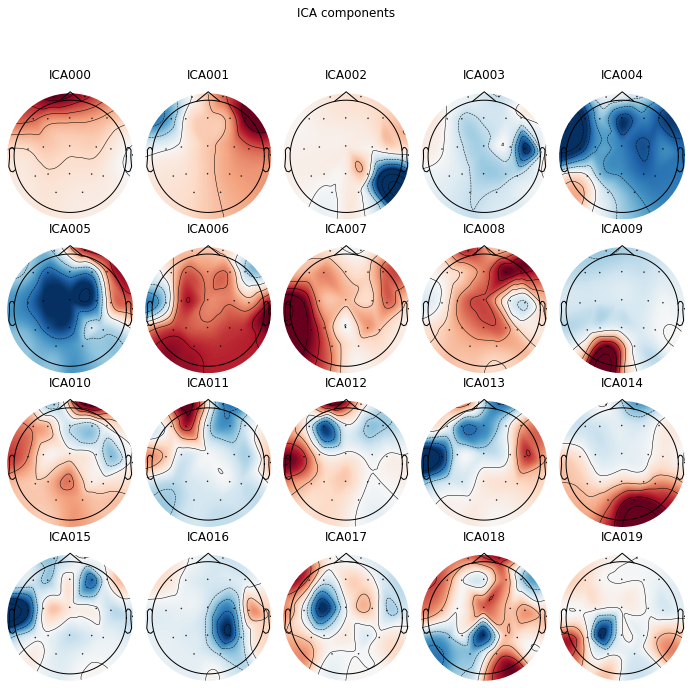

[<MNEFigure size 702x696.24 with 20 Axes>]

In [6]:
#Initialize and fit ICA algorithm, plot components

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter='auto')

ica.fit(raw)

raw.load_data()
ica.plot_sources(raw,show_scrollbars=False)
ica.plot_components()



In [12]:
#label components
labels=label_components(raw, ica, method='iclabel')['labels']
print(labels)
excluded_comps=[]
for i, label in enumerate(labels):
    if label!='brain':
        excluded_comps.append(i)
print(excluded_comps)

['eye blink', 'eye blink', 'other', 'other', 'brain', 'brain', 'other', 'brain', 'brain', 'other', 'muscle artifact', 'muscle artifact', 'other', 'muscle artifact', 'brain', 'other', 'brain', 'brain', 'other', 'brain']
[0, 1, 2, 3, 6, 9, 10, 11, 12, 13, 15, 18]


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 20 PCA components
Opening raw-browser...


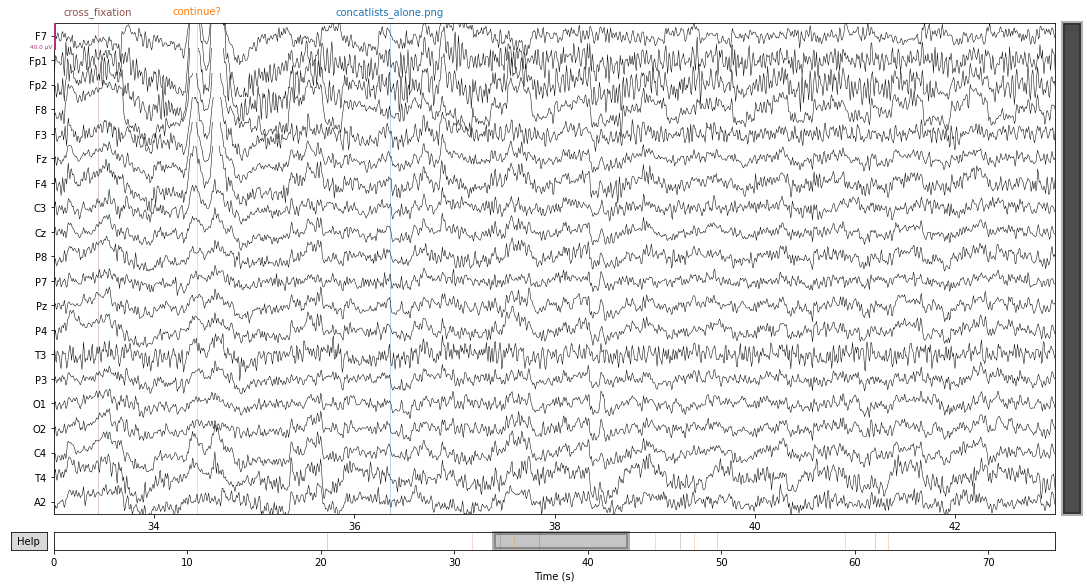

Opening raw-browser...


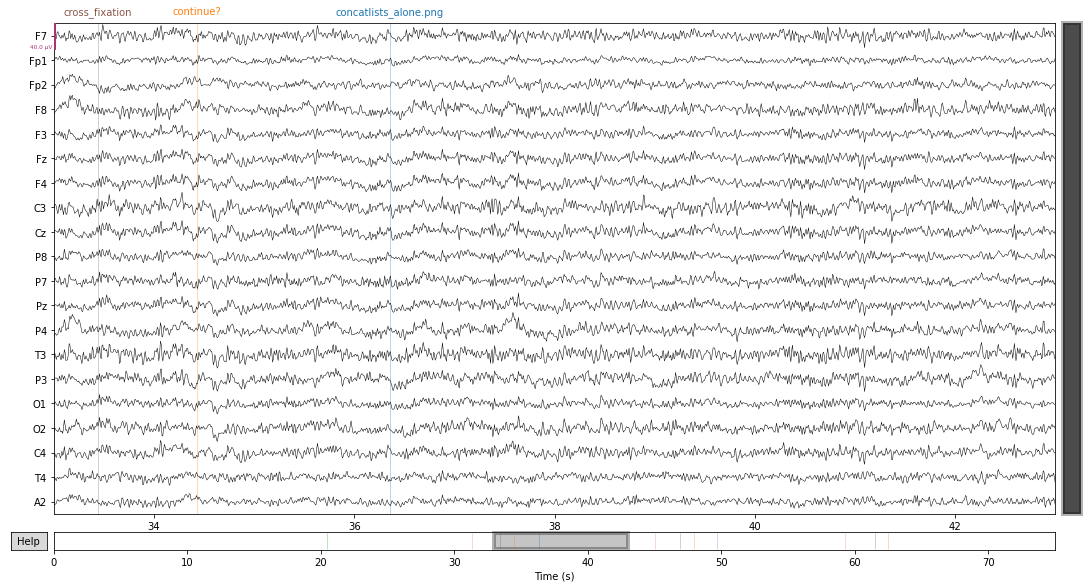

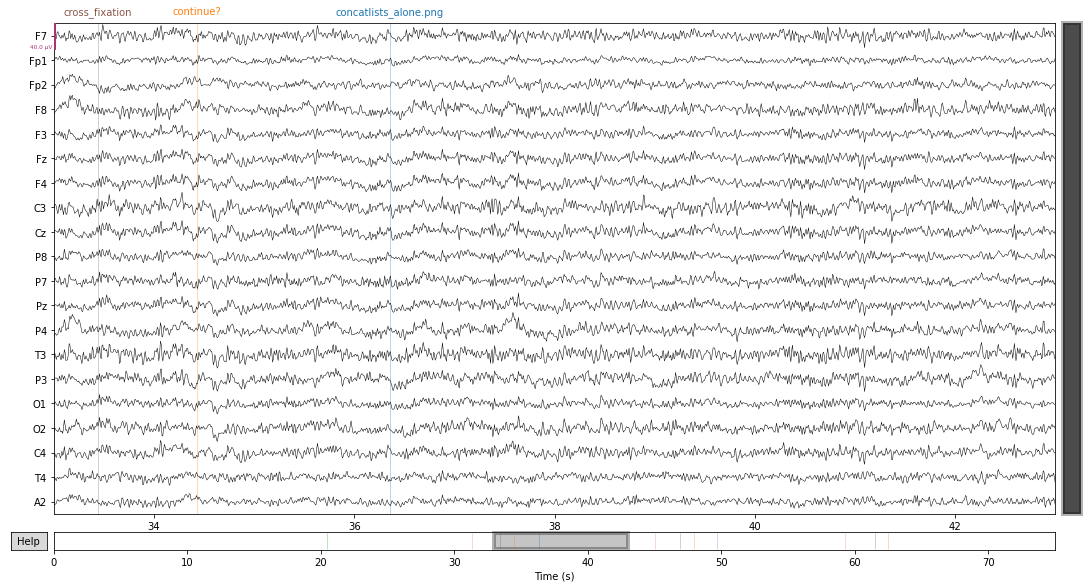

In [13]:
#Exclude artifacts and compare pre and post processing signals
#Eye blinks and other artifacts are removed

ica.exclude = excluded_comps

reconst_raw = raw.copy()
ica.apply(reconst_raw)
raw.plot(start=33, duration=10)
reconst_raw.plot(start=33, duration=10)

In [14]:
#print annotations - for stimulus sync
df_annot=reconst_raw.annotations.to_data_frame()
print(df_annot)


                        onset  duration                        description
0  1970-01-01 00:00:20.470556       0.0     countEvenNumbers_flowchart.png
1  1970-01-01 00:00:31.338408       0.0                             output
2  1970-01-01 00:00:33.437054       0.0                     cross_fixation
3  1970-01-01 00:00:34.430119       0.0                          continue?
4  1970-01-01 00:00:36.352791       0.0              concatlists_alone.png
5  1970-01-01 00:00:45.002003       0.0                             output
6  1970-01-01 00:00:46.929562       0.0                     cross_fixation
7  1970-01-01 00:00:47.928364       0.0                          continue?
8  1970-01-01 00:00:49.667336       0.0  countLetterInString_flowchart.png
9  1970-01-01 00:00:59.235390       0.0                             output
10 1970-01-01 00:01:01.477871       0.0                     cross_fixation
11 1970-01-01 00:01:02.477055       0.0                          continue?


In [15]:
#Get start and end time of the comprehension task 
task_start_time=float(str(df_annot["onset"][0]).split(':')[-1])
task_end_time=float(str(df_annot["onset"][2]).split(':')[-1])
print("start_time_task: "  +str(task_start_time))
print("end_time_task: " +str(task_end_time))

start_time_task: 20.470556
end_time_task: 33.437054


In [16]:
#Get start and end time of the cross task
cross_start_time=float(str(df_annot["onset"][2]).split(':')[-1])
cross_end_time=float(str(df_annot["onset"][4]).split(':')[-1])
print("start_time_cross: "  +str(cross_start_time))
print("end_time_cross: " +str(cross_end_time))

start_time_cross: 33.437054
end_time_cross: 36.352791


Opening raw-browser...


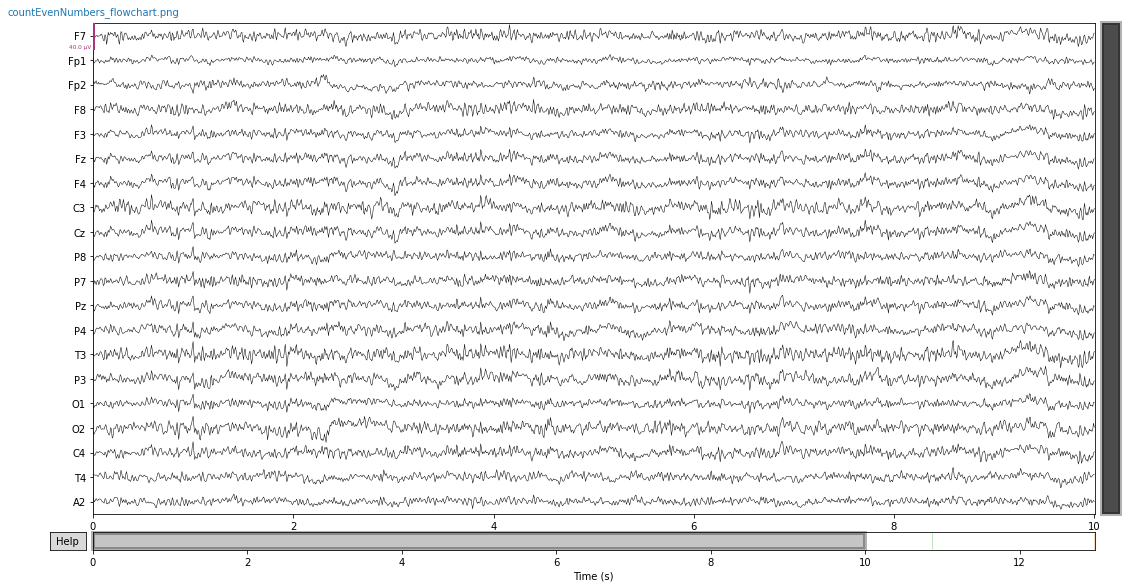

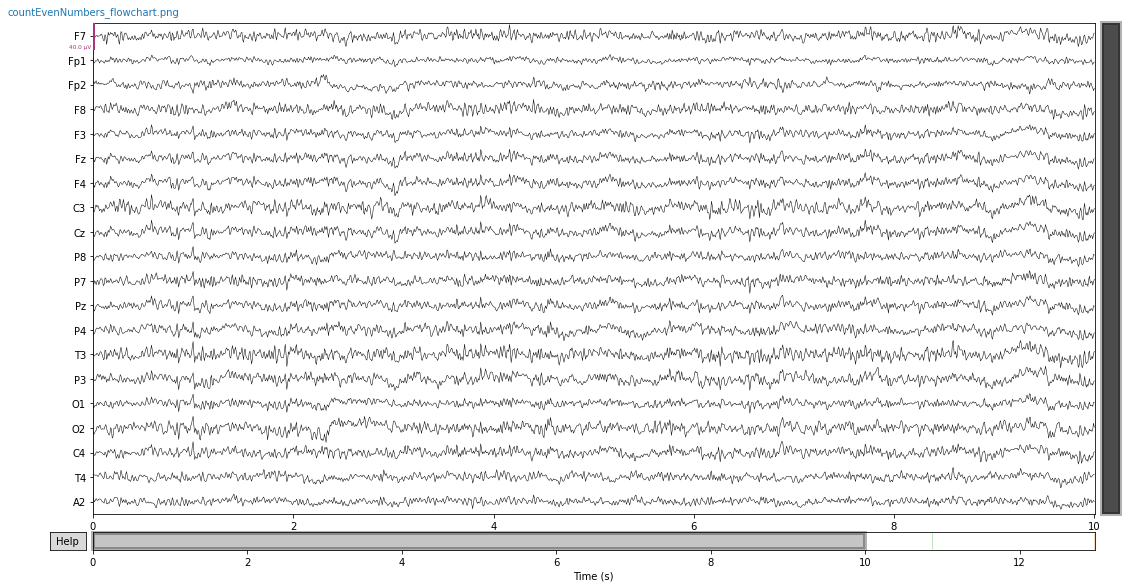

In [17]:
#Segment signals
raw1=reconst_raw.copy()
raw2=reconst_raw.copy()
comp_task=raw1.crop(task_start_time, task_end_time)
cross_task=raw2.crop(cross_start_time, cross_end_time)
cross_task2=cross_task.copy()

cross_total= mne.io.concatenate_raws([cross_task, cross_task2], on_mismatch='ignore')
comp_task.plot()

In [18]:
#Aux functions for EEG Analysis
def get_spectrum(data, sampling_rate, method='welch', decibel=False, resolution='auto'):
    """
    Calculate amplitude or power spectrum

    data: Should be of shape (n_channels, n_samples)
    sampling_rate: Sampling rate... (float)
    method:
        * welch for power spectrum using Welch's method (recommended)
        * ft for simple Fourier transform (amplitude spectrum)
        * ps for power spectrum using a simple fourier transform
    decibel: Convert spectrum to decibel (bool)
    """

    axis = -1

    n_channels, n_samples = data.shape

    if resolution == 'auto':
        n_frequencies = n_samples
    elif isinstance(resolution, (int, float)):
        n_frequencies = np.round(sampling_rate / resolution).astype('int')
    else:
        raise ValueError('\'{}\''.format(resolution))

    # Spectrum
    if method in ['ft', 'ps']:
        # Using FFT
        # Get (complex) spectrum
        spec = np.fft.fft(data, n=n_frequencies, axis=axis)
        freq = np.fft.fftfreq(n_frequencies) * sampling_rate

        # Convert to real positive-sided spectrum
        spec = np.abs(spec)
        nyquist = 0.5 * sampling_rate
        is_positive = np.logical_or(np.logical_and(freq >= 0, freq <= nyquist), freq == -nyquist)
        n_pos = np.sum(is_positive)
        is_positive = np.repeat(is_positive[np.newaxis], n_channels, axis=0)
        spec = np.reshape(spec[is_positive], (n_channels, n_pos))
        freq = np.abs(freq[is_positive])
        is_double = np.logical_and(freq > 0, freq < nyquist)
        is_double = np.repeat(is_double[np.newaxis], n_channels, axis=0)
        spec[is_double] = 2 * spec[is_double]

        if method in ['ps']:
            # Get power spectral density
            spec = (1 / (sampling_rate * n_frequencies)) * spec ** 2

            # Convert to decibel if required
            if decibel:
                spec = _to_decibel(spec)
    elif method in ['welch', 'welch_db']:
        # Using Welch method
        freq, spec = signal.welch(data, sampling_rate, nperseg=n_frequencies, detrend='constant', axis=axis)

        # Convert to decibel if required
        if decibel:
            spec = _to_decibel(spec)
    else:
        raise RuntimeError('Unknown method \'{}\''.format(method))

    return spec, freq


def bandpower(spec, freq, freqband, relative=False):
    """
    Get band power within specified frequency band
    Alternatively: https://raphaelvallat.com/bandpower.html
    """

    spec = np.asarray(spec)
    freq = np.asarray(freq)
    freqband = np.asarray(freqband)

    if spec.ndim != 1:
        raise ValueError('Input \'spec\' bad: {}'.format(spec.shape))

    if freqband.ndim != 1 and freqband.shape[-1] != 2:
        raise ValueError('Input \'freqband\' bad: {}'.format(freqband.shape))

    # Frequency resolution
    step_freq = freq[1] - freq[0]

    # Find closest indices of band in frequency vector
    is_in_freqband = np.logical_and(freq >= np.min(freqband), freq <= np.max(freqband))

    # Integral approximation of the spectrum using Simpson's rule
    bp = simps(spec[is_in_freqband], dx=step_freq)

    if relative:
        bp = bp / simps(spec, dx=step_freq)

    return bp


def _to_decibel(spec):
    return 10 * np.log10(spec)


def get_mental_work_load(eeg_path, sampling_rate=500):
    # read in eeg file
    eeg_data = eeg_path

    # get raw channel data and do mean average referencing
    eeg_data_raw = eeg_data.get_data()
    eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

    # extract channel names of eeg_data
    channel_names = list(eeg_data.to_data_frame().columns[1:])

    # create mock events for cutting eeg data (number, len, id)
    # events are set every 50 entry to move the window 0.1 seconds every time
    events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

    # create temporal eeg raw for cutting data into epochs
    tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

    # create epochs which have a 3 second window and operate on event id 1
    epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True,
                               verbose='ERROR')

    # calculate Mental Workload for each window
    mwl_array = []

    for epoch_data_raw in epochs:
        # perform power spectrum analysis on eeg data
        spectrum, frequency = get_spectrum(epoch_data_raw, sampling_rate, method='welch', decibel=False,
                                           resolution='auto')

        # calculate Mental Workload by dividing the power spectrum of the relative theta band power divided by relative alpha band power
        # on channel Fz for theta and Pc for alpha
        theata_power = bandpower(spectrum[channel_names.index("Fz"), :], frequency, [4.0, 8.0], relative=True)
        alpha_power = bandpower(spectrum[channel_names.index("Pz"), :], frequency, [8.0, 13.0], relative=True)
        MWL = theata_power / alpha_power

        # append Mental Workload to array
        mwl_array.append(MWL)
    return mwl_array



In [20]:
##Get cognitive load using Theta to Alpha Ratio
mwl_task = get_mental_work_load(comp_task)
mwl_base_line = get_mental_work_load(cross_total)
base_line_expected_value = np.mean(mwl_base_line)
base_line_variance = np.var(mwl_base_line)
mwl_z_score = (mwl_task - base_line_expected_value) / base_line_variance
print(mwl_z_score)

[-1.17171893 -1.15556592 -1.08146719 -0.99215637 -0.90413651 -0.81488569
 -0.73107058 -0.62864497 -0.54984641 -0.49915958 -0.41684265 -0.324237
 -0.24863938 -0.20824903 -0.09519196  0.04105158  0.08483568  0.07081922
  0.04458725 -0.04541192 -0.19635507 -0.36477243 -0.55542005 -0.73544677
 -0.87184336 -0.95297311 -0.9548695  -0.9053446  -0.80247409 -0.64649067
 -0.43577891 -0.17950206  0.11689217  0.40335517  0.65182482  0.81907278
  0.88747905  0.83813953  0.6883019   0.48500871  0.27838903  0.10827171
 -0.04833187 -0.18307368 -0.32024618 -0.4146855  -0.51526719 -0.5971096
 -0.64152706 -0.66204179 -0.67121491 -0.66347141 -0.6302105  -0.5667082
 -0.47327006 -0.35527357 -0.20228406 -0.04051657  0.12295225  0.25740334
  0.32801559  0.30190189  0.18693365  0.00794484 -0.21314227 -0.44054199
 -0.65223548 -0.83424446 -0.96695391 -1.06672088 -1.12441857 -1.13633266
 -1.10125708 -1.02007971 -0.90934591 -0.77990013 -0.63007856 -0.48894711
 -0.3581269  -0.232784   -0.16033579 -0.14133023 -0.131

In [21]:
print("MWLLength: " + str(len(mwl_z_score)))
print("MWLMean: " + str(np.mean(mwl_z_score)))
print("MWLMedian: " + str(np.median(mwl_z_score)))
print("MWLStd: " + str(np.std(mwl_z_score)))
print("MWLMin: " + str(np.min(mwl_z_score)))
print("MWLMax: " + str(np.max(mwl_z_score)))
print("PeakToPeak: " + str(np.ptp(mwl_z_score)))

MWLLength: 100
MWLMean: -0.3530971268863234
MWLMedian: -0.36144966815998014
MWLStd: 0.5290767250327348
MWLMin: -1.522201731416408
MWLMax: 0.8874790481451956
PeakToPeak: 2.4096807795616035
